# **Functions**

In [1]:
pip install -U jupyter


[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
#!pip install nibabel
!pip install nilearn


[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [3]:
# imports
import warnings
import sys

if not sys.warnoptions:
    warnings.simplefilter("ignore")

import os
import glob
import fnmatch

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import nibabel as nib
from nilearn.image import clean_img
from nilearn.signal import clean
from nilearn.input_data import NiftiMasker, MultiNiftiMasker
from nilearn.masking import compute_epi_mask


from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import (
    GridSearchCV,
    LeaveOneGroupOut,
    PredefinedSplit,
    KFold,
    GroupKFold,
)
from sklearn.feature_selection import SelectFpr, f_classif, SelectKBest
from sklearn.metrics import (
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    auc,
    roc_curve,
)

/Users/lingwei/opt/anaconda3/lib/python3.7/site-packages/nilearn/__init__.py:67: FutureWarning: Python 3.7 support is deprecated and will be removed in release 0.12 of Nilearn. Consider switching to Python 3.9 or 3.10.
  _python_deprecation_warnings()


In [4]:
# constants
subIDs = ["004", "005", "006", "024", "026"]
exp_phases = ["rest", "preremoval", "study", "postremoval"]
stim_labels = {0: "Rest", 1: "Scene", 2: "Face"}
op_labels = {0: "Rest", 1: "Maintain", 2: "Replace", 3: "Suppress"}
stim_onscreen = {0: "Rest", 1: "Image", 2: "Operation", 3: "ITI"}
brain_space = {"T1w": "T1w", "MNI": "MNI152NLin2009cAsym"}
descs = ["preproc_bold", "brain_mask"]
ROIs = ["wholebrain"]
# n_runs = np.arange(3) + 1
n_runs = 3
tr_shift = [5]
shift_TR = tr_shift[0]
TR = [1]
op_TR = TR[0]
TR_run = [366]
op_TRs_run = TR_run[0]

In [5]:
# paths
data_path = 'SDS384_FinalProjectData_Team2/raw bold/'
sub_design_path = 'SDS384_FinalProjectData_Team2/subejct_designs/'
combinedMask_path = 'SDS384_FinalProjectData_Team2/combined_masks/'
results_path = 'Results/'

In [6]:
# create a function to find a file of a given path
def find_file(pattern, path):
    result = []
    for root, dirs, files in os.walk(path):
        for name in files:
            if fnmatch.fnmatch(name, pattern):
                result.append(os.path.join(root, name))
        return result

In [7]:
# create a function to simultaneously load label df and time shift
def get_shifted_labels(task, shift_size_TR, rest_tag=0):
    # shift labels
    def shift_timing(label_df, TR_shift_size, tag=0):
        nvars = len(label_df.loc[0])
        shift = pd.DataFrame(
            np.zeros((TR_shift_size, nvars)) + tag, columns=label_df.columns
        )
        shifted = pd.concat([shift, label_df])
        # remove timepoints outside of scanner time after shift
        return shifted[: len(label_df)]

    print("Loading labels...")

    # assign which df from the task to pull
    if task == "preremoval":
        task_tag = "pre-localizer"
    if task == "postremoval":
        task_tag = "post-localizer"
    if task == "study":
        task_tag = "study"

    sub_design = f"*{task_tag}*events*"
    sub_design_file = find_file(sub_design, sub_design_path)
    sub_design_matrix = pd.read_csv(sub_design_file[0])

    shifted_df = shift_timing(sub_design_matrix, shift_size_TR, rest_tag)

    print("Labels have been loaded")
    print(sub_design)
    print(sub_design_file)
    print(sub_design_matrix)

    return shifted_df

In [8]:
# load in bold file for a given run
def load_epi_data(subID, run):
    epi_in = os.path.join(
        data_path,
        f"sub-{subID}",
        "func",
        f"sub-{subID}_task-study_run-{run}_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz",
    )
    epi_data = nib.load(epi_in)
    print("Loading data from %s" % (epi_in))
    return epi_data

In [9]:
test = load_epi_data('004', 1)

Loading data from SDS384_FinalProjectData_Team2/raw bold/sub-004/func/sub-004_task-study_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


In [10]:
# load mask data for a given roi
def load_mask(ROI, subID):
    for run in range(1, n_runs + 1):
        assert ROI in ROIs
        maskfile = os.path.join(
            combinedMask_path,
            "AllSubs_task-study_space-MNI152NLin2009cAsym_desc_brain_mask_COMBINED.nii.gz",
        )
        mask = nib.load(maskfile)
        print("Loaded %s mask for run %s" % (ROI, run))
    return mask

In [11]:
# create a function to mask the input data with the input mask
def mask_data(epi_data, mask):
    nifti_masker = NiftiMasker(mask_img=mask)
    epi_masked_data = nifti_masker.fit_transform(epi_data)
    return epi_masked_data

In [12]:
# create a function to load bold data, apply mask, and z-score data
def load_data(directory, subject_name, mask_name="", num_runs=3, zscore_data=False):
    existing_bold_data = f'SDS384_FinalProjectData_Team2/concatenated/operation decoding/bold/sub{subject_name}_study_MNI_masked_bold.npy'
    if os.path.exists(existing_bold_data):
      concatenated_data = np.load(existing_bold_data)
      print('Existing bold data loaded!')

      # if there is a mask supplied, load it now
      if mask_name is "":
        mask = None
      else:
        mask = load_mask(mask_name, subject_name)

      return concatenated_data, mask

    else:
      print('File not found :(')

      # cycle through the masks
      print("Processing Start ...")

      # if there is a mask supplied, load it now
      if mask_name is "":
          mask = None
      else:
          mask = load_mask(mask_name, subject_name)

      # cycle through the runs
      for run in range(1, num_runs + 1):
          epi_data = load_epi_data(subject_name, run)

          # mask the data if necessary
          if mask_name is not "":
              epi_mask_data = mask_data(epi_data, mask)
          else:
              # do a whole brain mask
              if run == 1:
                  # compute mask from epi
                  mask = compute_epi_mask(epi_data).get_data()
              else:
                  # get the intersection mask
                  # (set voxels that are within the mask on all runs to 1, set all other voxels to 0)
                  mask *= compute_epi_mask(epi_data).get_data()

              # reshape all of the data from 4D (X*Y*Z*time) to 2D (voxel*time): not great for memory
              epi_mask_data = epi_data.get_data().reshape(
                  mask.shape[0] * mask.shape[1] * mask.shape[2], epi_data.shape[3]
              )

          # transpose and z-score (standardize) the data
          if zscore_data == True:
              scaler = preprocessing.StandardScaler().fit(epi_mask_data)
              preprocessed_data = scaler.transform(epi_mask_data)
          else:
              preprocessed_data = epi_mask_data

          # concatenate the data
          if run == 1:
              concatenated_data = preprocessed_data
          else:
              concatenated_data = np.vstack((concatenated_data, preprocessed_data))

      # apply the whole-brain masking: First, reshape the mask from 3D (X*Y*Z) to 1D (voxel)
      # second, get indices of non-zero voxels, i.e., voxels inside the mask
      # third, zero out all the voxels outside the mask
      if mask_name is "":
          mask_vector = np.nonzero(
              mask.reshape(
                  mask.shape[0] * mask.shape[1] * mask.shape[2],
              )
          )[0]
          concatenated_data = concatenated_data[mask_vector, :]

      print("Data has been loaded for %s runs" % (num_runs))

      # save out to data folder
      np.save(
          f"SDS384_FinalProjectData_Team2/concatenated/operation decoding/bold/sub{subject_name}_study_MNI_masked_bold.npy",
          concatenated_data,
      )

      # return the list of mask data
      return concatenated_data, mask

In [13]:
# create function to do things similar to clearmem (feature selection = first half of each run; training/test = second half of each run)
def betweenSub_operation_sample(full_data, labels_df):
    # operations IDs - 1: maintain, 2: replace, 3: suppress
    # stim on screen - 1: image, 2: operation, 3: ITI

    operation_list = labels_df["condition"]
    stim_onscreen = labels_df["stim_present"]
    run_list = labels_df["run"]

    # define operation period
    operation_index = np.where(np.logical_or(stim_onscreen == 2, stim_onscreen == 3))[0]
    rest_index = []
    runs = run_list.unique()[1:]

    operation_val = operation_list.values[operation_index]
    run_val = run_list.values[operation_index]

    # we want the first half of each run for feature selection
    bold_data = []
    operation_sample = operation_val

    sub_loop = 0
    for sub in subIDs:
        bold = full_data[f"{sub}"][operation_index]

        if sub_loop == 0:
            bold_data = bold
            sub_loop = sub_loop + 1
        else:
            bold_data = np.concatenate((bold_data, bold))

    subject_sample = np.repeat(range(0, 5), 900)
    op_labels = np.tile(operation_sample, 5)

    return bold_data, op_labels, subject_sample

In [18]:
#!pip install xgboost
from xgboost import XGBRegressor

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 5.7 MB/s eta 0:00:0000:0100:010m

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [19]:
def betweenSub_decode_model(bold_data, op_labels, subject_sample):
    scores = []
    decision_scores = []
    test_labels = []
    pred_probs = []
    confusion_matrices = []
    aucs = []
    evidences = []
    roc_aucs = []

    ps = PredefinedSplit(subject_sample)
    for train, test in ps.split():
        train_data = bold_data[train]
        test_data = bold_data[test]
        train_label = op_labels[train]
        test_label = op_labels[test]

        # feature selection
        Fselect_fpr = SelectFpr(f_classif, alpha=0.001).fit(train_data, train_label)
        bold_train_subject = Fselect_fpr.transform(train_data)
        bold_test_subject = Fselect_fpr.transform(test_data)

        # train with selected penalty        
        log_reg = XGBRegressor(max_depth= 10), objective='reg:squarederror')
        log_reg.fit(bold_train_subject, train_label)

        # now test on the held out subject
        score = log_reg.score(bold_test_subject, test_label)
        decision_score = log_reg.decision_function(bold_test_subject)

        classes = np.unique(test_label).size

        # calculate auc for each operation
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(classes):
            temp_label = np.zeros(test_label.size)
            label_index = np.where(test_label == (i + 1))
            temp_label[label_index] = 1

            fpr[i], tpr[i], _ = roc_curve(temp_label, decision_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # compute auc
        auc_score = roc_auc_score(
            test_label, log_reg.predict_proba(bold_test_subject), multi_class="ovr"
        )

        # get predicted scores
        predict = log_reg.predict(bold_test_subject)
        predict_prob = log_reg.predict_proba(bold_test_subject)

        # set up confusion matrix
        true_values = np.asarray([np.sum(test_label == i) for i in [1, 2, 3]])
        cm = (
            confusion_matrix(test_label, predict, labels=list([1, 2, 3]))
            / true_values[:, None]
            * 100
        )

        scores.append(score)
        aucs.append(auc_score)
        confusion_matrices.append(cm)

        evidence = 1.0 / (1.0 + np.exp(-log_reg.decision_function(bold_test_subject)))
        evidences.append(evidence)

        roc_aucs.append(roc_auc)

        test_labels.append(test_label)
        pred_probs.append(predict_prob)
        decision_scores.append(decision_score)

    roc_aucs = pd.DataFrame(data=roc_aucs)
    scores = np.asarray(scores)
    aucs = np.asarray(aucs)
    confusion_matrices = np.stack(confusion_matrices)
    evidences = np.stack(evidences)

    test_labels = np.stack(test_labels)
    pred_probs = np.stack(pred_probs)
    decision_scores = np.stack(decision_scores)

    print(
        f"\nClassifier score: \n"
        f"scores: {scores.mean()} sd: {scores.std()}\n"
        f"auc scores: {aucs.mean()} sd: {aucs.std()}\n"
        f"average confusion matrix:\n"
        f"{confusion_matrices.mean(axis=0)}"
    )

    return (
        scores,
        aucs,
        confusion_matrices,
        evidences,
        test_labels,
        decision_scores,
        roc_aucs,
    )

In [20]:
# XGBoost
def betweenSub_decode_model_XGBoost(bold_data, op_labels, subject_sample):
    scores = []
    decision_scores = []
    test_labels = []
    pred_probs = []
    confusion_matrices = []
    aucs = []
    evidences = []
    roc_aucs = []

    ps = PredefinedSplit(subject_sample)
    for train, test in ps.split():
        train_data = bold_data[train]
        test_data = bold_data[test]
        train_label = op_labels[train]
        test_label = op_labels[test]

        # feature selection
        Fselect_fpr = SelectFpr(f_classif, alpha=0.001).fit(train_data, train_label)
        bold_train_subject = Fselect_fpr.transform(train_data)
        bold_test_subject = Fselect_fpr.transform(test_data)

        # train with selected penalty
        log_reg = LogisticRegression(penalty="l2", solver="lbfgs", C=50, max_iter=1000)
        log_reg.fit(bold_train_subject, train_label)

        # now test on the held out subject
        score = log_reg.score(bold_test_subject, test_label)
        decision_score = log_reg.decision_function(bold_test_subject)

        classes = np.unique(test_label).size

        # calculate auc for each operation
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(classes):
            temp_label = np.zeros(test_label.size)
            label_index = np.where(test_label == (i + 1))
            temp_label[label_index] = 1

            fpr[i], tpr[i], _ = roc_curve(temp_label, decision_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # compute auc
        auc_score = roc_auc_score(
            test_label, log_reg.predict_proba(bold_test_subject), multi_class="ovr"
        )

        # get predicted scores
        predict = log_reg.predict(bold_test_subject)
        predict_prob = log_reg.predict_proba(bold_test_subject)

        # set up confusion matrix
        true_values = np.asarray([np.sum(test_label == i) for i in [1, 2, 3]])
        cm = (
            confusion_matrix(test_label, predict, labels=list([1, 2, 3]))
            / true_values[:, None]
            * 100
        )

        scores.append(score)
        aucs.append(auc_score)
        confusion_matrices.append(cm)

        evidence = 1.0 / (1.0 + np.exp(-log_reg.decision_function(bold_test_subject)))
        evidences.append(evidence)

        roc_aucs.append(roc_auc)

        test_labels.append(test_label)
        pred_probs.append(predict_prob)
        decision_scores.append(decision_score)

    roc_aucs = pd.DataFrame(data=roc_aucs)
    scores = np.asarray(scores)
    aucs = np.asarray(aucs)
    confusion_matrices = np.stack(confusion_matrices)
    evidences = np.stack(evidences)

    test_labels = np.stack(test_labels)
    pred_probs = np.stack(pred_probs)
    decision_scores = np.stack(decision_scores)

    print(
        f"\nClassifier score: \n"
        f"scores: {scores.mean()} sd: {scores.std()}\n"
        f"auc scores: {aucs.mean()} sd: {aucs.std()}\n"
        f"average confusion matrix:\n"
        f"{confusion_matrices.mean(axis=0)}"
    )

    return (
        scores,
        aucs,
        confusion_matrices,
        evidences,
        test_labels,
        decision_scores,
        roc_aucs,
    )

Running between-subject classification...
Existing bold data loaded!
Loaded wholebrain mask for run 1
Loaded wholebrain mask for run 2
Loaded wholebrain mask for run 3
Existing bold data loaded!
Loaded wholebrain mask for run 1
Loaded wholebrain mask for run 2
Loaded wholebrain mask for run 3
Existing bold data loaded!
Loaded wholebrain mask for run 1
Loaded wholebrain mask for run 2
Loaded wholebrain mask for run 3
Existing bold data loaded!
Loaded wholebrain mask for run 1
Loaded wholebrain mask for run 2
Loaded wholebrain mask for run 3
Existing bold data loaded!
Loaded wholebrain mask for run 1
Loaded wholebrain mask for run 2
Loaded wholebrain mask for run 3
Loading labels...
Labels have been loaded
*study*events*
['SDS384_FinalProjectData_Team2/subejct_designs/study_events.csv']
      phase  trial  order  plan_onset  onset  jitter  run  condition  \
0         3      1      1           0      0       2    1          2   
1         3      1      1           0      0       2    1   

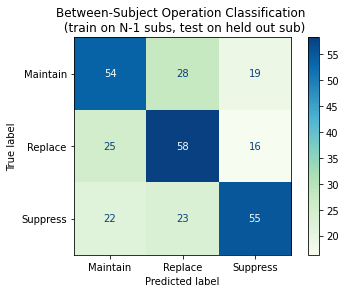

<Figure size 432x288 with 0 Axes>

In [31]:
betweenSub_classification_XGB()

<Figure size 432x288 with 0 Axes>

In [33]:
# set up function to run whole classification
def betweenSub_classification_XGB():
    print("Running between-subject classification...")
    # load data
    full_data = {}
    for sub in subIDs:
        full_data[f"{sub}"], _ = load_data(
            directory=data_path,
            subject_name=sub,
            mask_name="wholebrain",
            zscore_data=True,
        )

    # load labels
    stim_labels_allruns = get_shifted_labels(task="study", shift_size_TR=shift_TR)
    print(f"Label shape: {stim_labels_allruns.shape}")

    # set up train and test data
    bold_data, op_labels, subject_sample = betweenSub_operation_sample(
        full_data, stim_labels_allruns
    )

    # run model
    print("Running model...")

    (
        scores,
        aucs,
        confusion_matrices,
        evidences,
        test_labels,
        decision_scores,
        roc_aucs,
    ) = betweenSub_decode_model_XGBoost(bold_data, op_labels, subject_sample)

    mean_score = scores.mean()
    print(f"Mean score: {mean_score}")

    # save aucs for each operation to csv in results folder of working directory
    aucs_df = pd.DataFrame(columns=["Maintain", "Replace", "Suppress", "sub"])
    aucs_df["Maintain"] = roc_aucs.loc[:, 0]
    aucs_df["Replace"] = roc_aucs.loc[:, 1]
    aucs_df["Suppress"] = roc_aucs.loc[:, 2]
    aucs_df["sub"] = [*range(0, 5)]
    
    # save to the results folder
    aucs_df.to_csv('Results/output.csv')

    # Create average confusion matrix figure
    avg_cm = confusion_matrices.mean(axis=0)

    avg_disp = ConfusionMatrixDisplay(
        confusion_matrix=avg_cm, display_labels=["Maintain", "Replace", "Suppress"]
    )
    avg_disp.plot(cmap=plt.cm.GnBu)
    plt.title(
        "Between-Subject Operation Classification \n (train on N-1 subs, test on held out sub)"
    )

    # Show the figures
    plt.savefig('Results/classification_XGBoost.png', dpi = 300)
    plt.show()
  

In [42]:
auc_merge_within

,Unnamed: 0,Maintain,Replace,Suppress,sub
0,0,0.634432,0.646024,0.740506,0
1,1,0.723712,0.755755,0.777644,1
2,2,0.712882,0.726994,0.688244,2
3,3,0.728417,0.716061,0.807028,3
4,4,0.738301,0.767197,0.853567,4


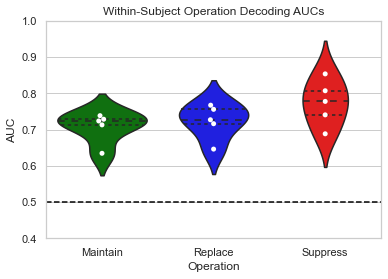

In [46]:
# %% plot aucs as violin plot for each operation (points for individuals subjects)
#  merge each subject auc data
path = "Results/*.csv"
files = glob.glob(path)
auc_merge_within = pd.concat([pd.read_csv(file) for file in files], ignore_index=True)

# plot
sns.set(style="whitegrid")
color_dict = {"Maintain": "green", "Replace": "blue", "Suppress": "red"}

plt.ylim(0.4, 1)
sns.violinplot(
    x="operation",
    y="auc",
    data=auc_merge_within,
    inner="quartile",
    palette=color_dict.values(),
)
sns.swarmplot(x="operation", y="auc", data=auc_merge_within, color="white")
plt.axhline(y=0.5, color="black", linestyle="--")

plt.xlabel("Operation")
plt.ylabel("AUC")
plt.title("Within-Subject Operation Decoding AUCs")

plt.savefig(
    "Results/withinSub_op_auc_violin_XGBoost.png"
)
plt.show()

In [23]:
# set up function to run whole classification
def betweenSub_classification():
    print("Running between-subject classification...")
    # load data
    full_data = {}
    for sub in subIDs:
        full_data[f"{sub}"], _ = load_data(
            directory=data_path,
            subject_name=sub,
            mask_name="wholebrain",
            zscore_data=True,
        )

    # load labels
    stim_labels_allruns = get_shifted_labels(task="study", shift_size_TR=shift_TR)
    print(f"Label shape: {stim_labels_allruns.shape}")

    # set up train and test data
    bold_data, op_labels, subject_sample = betweenSub_operation_sample(
        full_data, stim_labels_allruns
    )

    # run model
    print("Running model...")

    (
        scores,
        aucs,
        confusion_matrices,
        evidences,
        test_labels,
        decision_scores,
        roc_aucs,
    ) = betweenSub_decode_model(bold_data, op_labels, subject_sample)

    mean_score = scores.mean()
    print(f"Mean score: {mean_score}")

    # save aucs for each operation to csv in results folder of working directory
    aucs_df = pd.DataFrame(columns=["Maintain", "Replace", "Suppress", "sub"])
    aucs_df["Maintain"] = roc_aucs.loc[:, 0]
    aucs_df["Replace"] = roc_aucs.loc[:, 1]
    aucs_df["Suppress"] = roc_aucs.loc[:, 2]
    aucs_df["sub"] = [*range(0, 5)]

    # Create average confusion matrix figure
    avg_cm = confusion_matrices.mean(axis=0)

    avg_disp = ConfusionMatrixDisplay(
        confusion_matrix=avg_cm, display_labels=["Maintain", "Replace", "Suppress"]
    )
    avg_disp.plot(cmap=plt.cm.GnBu)
    plt.title(
        "Between-Subject Operation Classification \n (train on N-1 subs, test on held out sub)"
    )

    # Show the figures
    plt.show()

# **Run first model**

Running between-subject classification...
Existing bold data loaded!
Loaded wholebrain mask for run 1
Loaded wholebrain mask for run 2
Loaded wholebrain mask for run 3
Existing bold data loaded!
Loaded wholebrain mask for run 1
Loaded wholebrain mask for run 2
Loaded wholebrain mask for run 3
Existing bold data loaded!
Loaded wholebrain mask for run 1
Loaded wholebrain mask for run 2
Loaded wholebrain mask for run 3
Existing bold data loaded!
Loaded wholebrain mask for run 1
Loaded wholebrain mask for run 2
Loaded wholebrain mask for run 3
Existing bold data loaded!
Loaded wholebrain mask for run 1
Loaded wholebrain mask for run 2
Loaded wholebrain mask for run 3
Loading labels...
Labels have been loaded
*study*events*
['SDS384_FinalProjectData_Team2/subejct_designs/study_events.csv']
      phase  trial  order  plan_onset  onset  jitter  run  condition  \
0         3      1      1           0      0       2    1          2   
1         3      1      1           0      0       2    1   

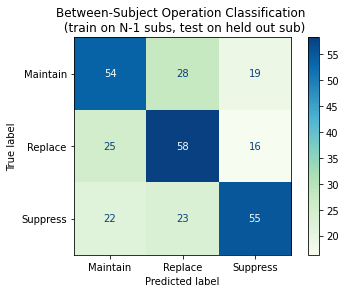

In [16]:
# run first model (classification of all operations)
betweenSub_classification()

In [ ]:
# run
for i in range(len(subIDs)):
    sub = subIDs[i]
    subID = sub

    bold_mask_data_all, _ = load_data(
        directory=data_path,
        subject_name=subID,
        mask_name="wholebrain",
        zscore_data=True
    )



In [37]:
# create a function to run between-subject classification
def betweenSub_classification():
  print('Running between-subject classification...')

  # load data
  full_data = {}
  for sub in subIDs:
    full_data[f'{sub}'], _ = load_data(
        directory = data_path,
        subject_name = sub,
        mask_name = 'wholebrain',
        zscore_data = True,
    )

  # load labels
  stim_labels_allruns = get_shifted_labels(task='study', shift_size_TR=shift_TR)
  print(f'Label shape: {stim_labels_allruns.shape}')

  # set up train and test data
  bold_data, op_labels, subject_sample = betweenSub_operation_sample(
      full_data, stim_labels_allruns
  )

  # run model
  print('Running model...')

  (
      scores,
      aucs,
      confusion_matrices,
      evidences,
      test_labels,
      decision_scores,
      roc_aucs,
  ) = betweenSub_decode_model(bold_data, op_labels, subject_sample)

  mean_score = scores.mean()
  print(f'Mean score: {mean_score}')

  # save aucs for each operation to csv in results folder of working directory


In [39]:
filelist = [f for f in
            os.listdir('SDS384_FinalProjectData_Team2/subejct_designs')
            if
            f.endswith('.csv')]

In [ ]:
sub_design_path

'SDS384_FinalProjectData_Team2/subejct_designs/'

In [40]:
data_test = pd.read_csv(sub_design_path + filelist[1])

In [41]:
data_test

,subject,image_num,condition_num,old_novel,memory,familiar_score,resp
0,4,101,0,2,1,1,1
1,4,106,0,3,1,2,4
2,4,109,0,2,0,2,2
3,4,107,1,1,1,2,4
4,4,56,2,1,1,1,4
...,...,...,...,...,...,...,...
175,4,149,1,1,1,3,4
176,4,49,3,1,1,5,4
177,4,40,0,3,1,2,4
178,4,104,3,1,1,3,4


In [26]:
filelist = [f for f in
            os.listdir('SDS384_FinalProjectData_Team2/memory')
            if
            f.endswith('.csv')]

for i in range(len(filelist)):
  filename = ('SDS384_FinalProjectData_Team2/memory/' + filelist[i])

  memory_data = pd.read_csv(filename)

  participant = memory_data.iloc[0]['subject']

  memory_data = memory_data.assign(Suppress_Forget=np.where(((memory_data['memory'] == 0) & (memory_data['condition_num'] == 3)), 1, 0))

  memory_data.to_csv(f'Results/{participant}_mem_data.csv', index=False)


import glob
mem_path = 'Results/*.csv'
mem_files = glob.glob(mem_path)
mem_data_merge = pd.concat([pd.read_csv(mem_file) for mem_file in mem_files],
                           ignore_index=True)

agg_select = ['Suppress_Forget']

agg_dict = {col: 'sum' for col in agg_select}
rename_dict = {col: col.lower() + '_sum' for col in agg_select}

data_agg = mem_data_merge.groupby(['subject']).agg(agg_dict).rename(columns=rename_dict).reset_index()


median_value = data_agg['suppress_forget_sum'].median()
print(median_value)

data_agg.head()

FileNotFoundError: [Errno 2] No such file or directory: 'SDS384_FinalProjectData_Team2/memory'

In [ ]:
def betweenSub_operation_sample(full_data, labels_df):
  # operation IDs - 1: maintain, 2: replace, 3: suppress
  # stim on-screen - 1: image, 2: operation, 3: ITI
